# S4E6 Classification with an Academic Success Dataset

## Imports

In [36]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data 
PLAYGROUND_PATH = './data/'
ORIGINAL_PATH = './data/'

train = pd.read_csv(PLAYGROUND_PATH + 'train.csv', index_col='id')
test = pd.read_csv(PLAYGROUND_PATH + 'test.csv', index_col='id')
original = pd.read_csv(ORIGINAL_PATH + 'data.csv', sep=';')

# rename one column in original due to reading error
original.rename(columns={'Daytime/evening attendance\t': 'Daytime/evening attendance'}, inplace=True)

## Basic EDA

In [37]:
%%script false --no-raise-error

# check for NA 
print(train.isnull().sum())
print(test.isnull().sum())

In [38]:
features = train.columns 
features = features.drop('Target')

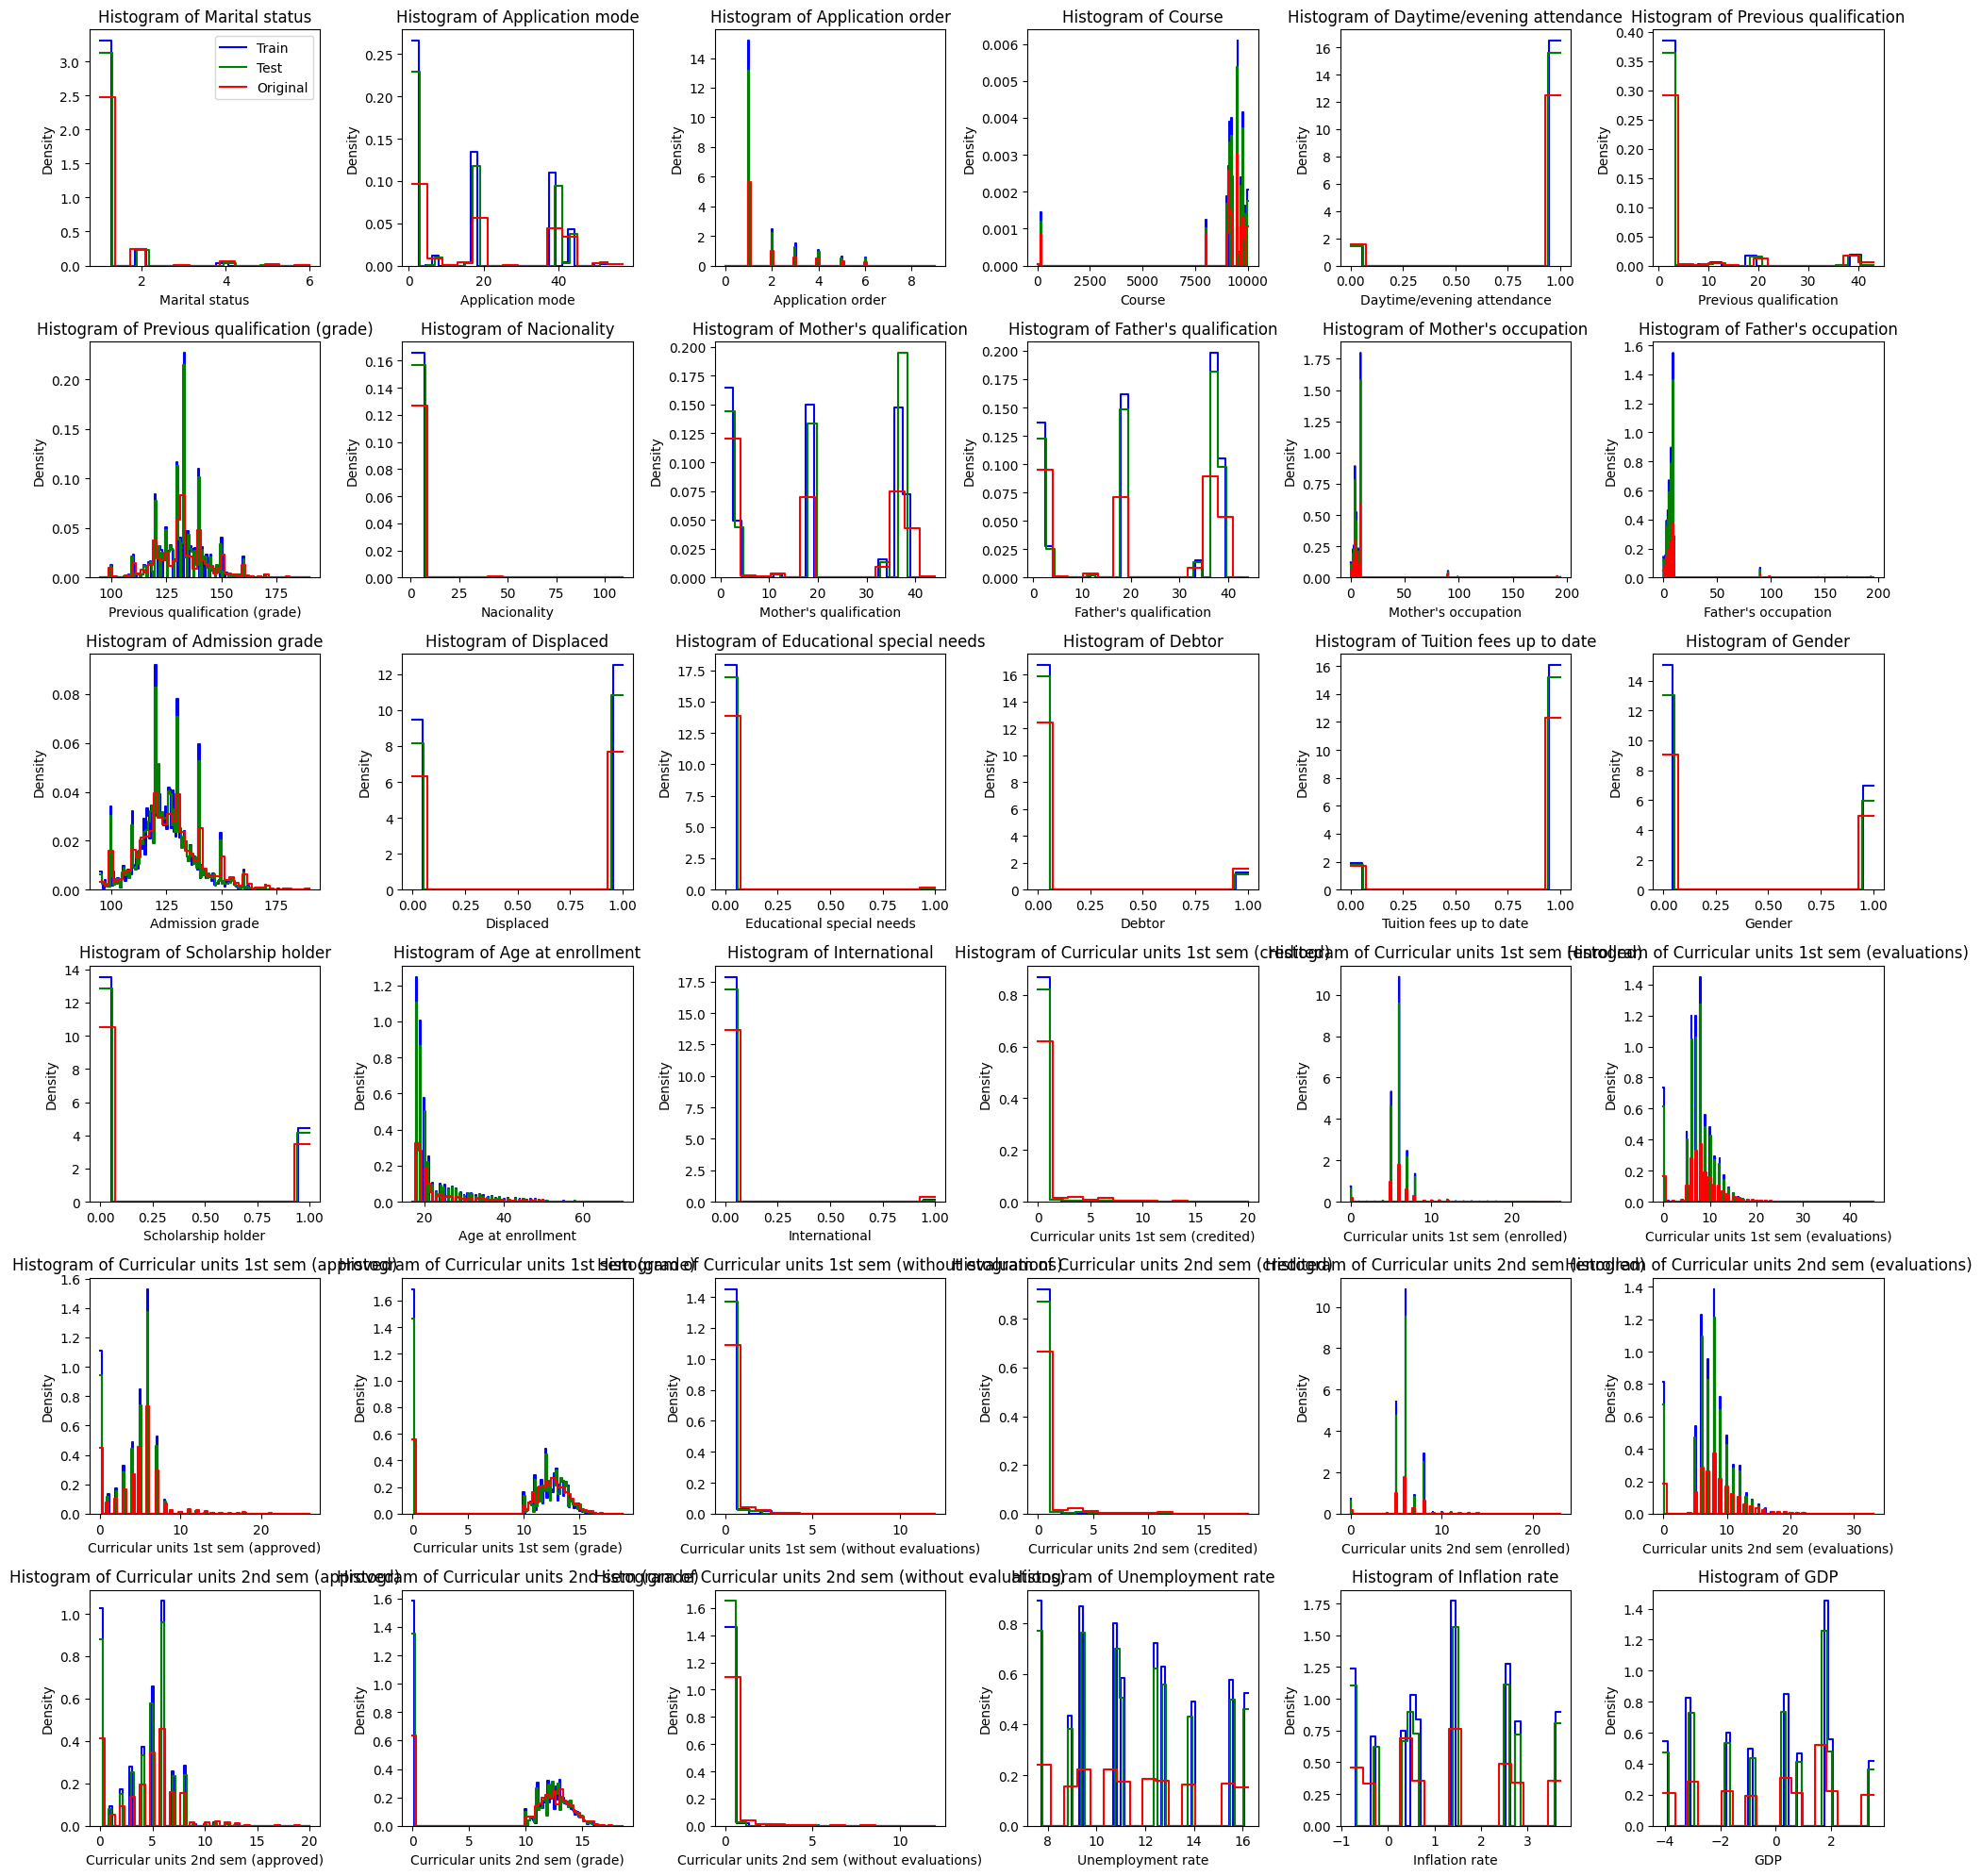

In [39]:
# Plot histograms of the features
plt.figure(figsize=(20, 20))
n_rows = 6
n_cols = 6

for i, feature in enumerate(features, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(train[feature], stat="density", color="blue", label="Train", kde=False, element="step", fill=False)
    sns.histplot(test[feature], stat="density", color="green", label="Test", kde=False, element="step", fill=False)
    sns.histplot(original[feature], stat="density", color="red", label="Original", kde=False, element="step", fill=False)
    
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    if i == 1:  # Only show legend in the first subplot for clarity
        plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [40]:
# encode the target
target_map = {'Graduate': 0, 'Enrolled': 1, 'Dropout': 2}
reverse_target_map = {v: k for k, v in target_map.items()}
train['Target'] = train['Target'].map(target_map)
original['Target'] = original['Target'].map(target_map)

In [41]:
combined = pd.concat([train, original], axis=0, ignore_index=True)

In [42]:
# calculate the correlation matrix to target and print them in absolute values
correlation_matrix = combined.corr()
correlation_with_target = correlation_matrix['Target'].abs().sort_values(ascending=False)
print(correlation_with_target)

Target                                            1.000000
Curricular units 2nd sem (approved)               0.771793
Curricular units 1st sem (approved)               0.712474
Curricular units 2nd sem (grade)                  0.711071
Curricular units 1st sem (grade)                  0.652284
Tuition fees up to date                           0.415209
Scholarship holder                                0.388816
Gender                                            0.324285
Application mode                                  0.318380
Age at enrollment                                 0.315500
Curricular units 2nd sem (enrolled)               0.280224
Curricular units 1st sem (enrolled)               0.253813
Debtor                                            0.247064
Curricular units 2nd sem (evaluations)            0.207542
Admission grade                                   0.169705
Displaced                                         0.147981
Course                                            0.1464

In [44]:
# train a simple lightgbm model as base model 
import lightgbm as lgb

X_train = combined.drop('Target', axis=1)
y_train = combined['Target']

model = lgb.LGBMClassifier()
model.fit(X_train, y_train)

predictions = model.predict(test)
predictions = [reverse_target_map[pred] for pred in predictions]

# save the predictions
submission = pd.DataFrame({'id': test.index, 'Target': predictions})
submission.to_csv('submissions/lgb_base.csv', index=False)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1399
[LightGBM] [Info] Number of data points in the train set: 80942, number of used features: 36
[LightGBM] [Info] Start training from score -0.743308
[LightGBM] [Info] Start training from score -1.637909
[LightGBM] [Info] Start training from score -1.108433
